# Code 

*Note: this notebook should be converted to PDF with the following command:*

```
nbpublish -pdf <notebook-name>.ipynb
```


*You have to install [IPyPublish](https://ipypublish.readthedocs.io/en/latest/index.html) first. Also note that this cell will not be part of the output since it contains the metadata tag `ignore=True`.*

## Imports

In [1]:
# https://stackoverflow.com/a/39566040/11552622
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}

In [2]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib(output=('pdf','svg'), rcparams=rcparams)
pd = nb_setup.setup_pandas(escape_latex=False)
pd.set_option('precision', 2)

In [3]:
import numpy as np
import seaborn as sns
import numpy as np

## Setup paths

In [4]:
# Define paths
filename_table = 'table.csv'
filename_exact = 'Xexact.csv'
filename_pred = 'Xpredicted.csv'
filename_Y = 'Ytest.txt'
filename_Ypred = 'Ytestpred.txt'
results_folders_LVAD = {
    4000: '/media/maousi/Data/tmp/simulations_2020_03_21/results/',
    5000: '/media/maousi/Data/tmp/simulation_LVAD_RPM5000_2020_04_21/results/',
    6000: '/media/maousi/Data/tmp/simulation_LVAD_RPM6000_2020_04_22/results/'
}

## Utility functions

### Results table

In [5]:
# Define utility function to format results table
def format_table(table):
    table.index = [
        'Min exact', 'Max exact',
        'Mean exact', 'SD exact',
        'Min predicted', 'Max predicted',
        'Mean predicted', 'SD predicted',
        'Mean error matrix', 'Mean rel error * 100',
        'SD error', 'CI min',
        'CI max',
    ]
    table.columns = [
        'HR','SAPM','SAPS','SAPD',
        'PAPM','PAPS','PAPD','LVEF',
        'LVEDV', 'LVESV', 'CI', 'PCPW'
    ]
    table.loc['Mean rel error * 100', :] = table.loc['Mean rel error * 100', :] * 100

In [6]:
# Load the table, format it and return it
def get_results_table(RPM):
    df = pd.read_csv(results_folders_LVAD[RPM]+filename_table, header=None)
    format_table(df)
    return df

### DNN performance

In [7]:
def load_Ys(RPM):
    Ytest = pd.read_csv(results_folders_LVAD[RPM]+filename_Y, sep=' ', header=None)
    Ytestpred = pd.read_csv(results_folders_LVAD[RPM]+filename_Ypred, sep=' ', header=None)
    return Ytest, Ytestpred

In [8]:
def plot_dnn_performance(RPM):
    params = [r'$E_{max,lv}$', r'$E_{max,lv,0}$',
              r'$G_{E_{max,lv}}$', r'$k_{E,lv}$']
    fig, ax = plt.subplots(2, 2, figsize=(10,6))
    Ytest, Ypred = load_Ys(RPM)
    
    for i,a in enumerate(ax.ravel()):
        a.scatter(Ytest.loc[:, i], Ypred.loc[:, i], s=3)
        a.set_title(params[i])
        a.set_xlabel(r'Exact')
        a.set_ylabel(r'Predicted')
    
    offset = .0005
    ax[1, 1].set_xlim([Ytest.loc[:, 3].min()-offset, Ytest.loc[:, 3].max()+offset])
    ax[1, 1].set_ylim([Ypred.loc[:, 3].min()-offset, Ypred.loc[:, 3].max()+offset])
    
    plt.subplots_adjust(wspace=0.3, hspace=.5)
    
    return
    axs[0, 0].scatter(Ytest[:, 0], Ypred[:, 0])
    axs[0, 0].set_title(r'Left Ventricle $E_{meax,0}$')
    axs[0, 0].set_xlabel('real parameter')
    axs[0, 0].set_ylabel('predicted parameter')
    axs[0, 1].scatter(Ytest[:, 1], Ypred[:, 1])
    axs[0, 1].set_title('Left Ventricle $E_{max,Ref,0}')
    axs[0, 1].set_xlabel('real parameter')
    axs[0, 1].set_ylabel('predicted parameter')
    axs[1, 0].scatter(Ytest[:, 2], Ypred[:, 2])
    axs[1, 0].set_title('Left Ventricle AGain_Emax')
    axs[1, 0].set_xlabel('real parameter')
    axs[1, 0].set_ylabel('predicted parameter')
    axs[1, 1].scatter(Ytest[:, 3], Ypred[:, 3])
    axs[1, 1].set_title('Left Ventricle kE')
    axs[1, 1].set_xlabel('real parameter')
    axs[1, 1].set_ylabel('predicted parameter')
    #axs[1, 1].set_xlim(normdata['parammins'][3], normdata['parammaxs'][3])
    #axs[1, 1].set_ylim(normdata['parammins'][3], normdata['parammaxs'][3])

# Introduction

## Aim

Compare predicted vs exact hemodynamics quantities for different RPM levels of the Heart Mate III device.

## Methods

### LVAD HQ curves

HQ curves were estimated from the graph provided in the Heart Mate III device manual: 



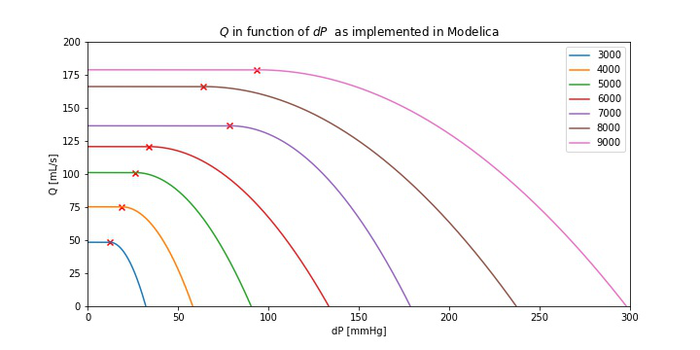

In [29]:
nb_setup.images_hconcat([#'../res/modelica/HM3-HQ-curve-reconstructed.svg',
                         '../res/modelica/HM3-HQ-curve-reversed.jpg'])

Two important simplifying assumptions:

* **Retrograde flow is artifically prevented** by setting $Q_{LVAD}=0$ in case the flow becomes negative
* For each RPM level, when the pressure head $dP$ becomes too small, we assume a constant flow rate $Q$ due to the lack of data available for small pressure differences

### Dataset generation

3 different datasets of 10'000 simulations each were obtained, by modifying the following parameters:

* Heart failure level parameters: 4 parameters, $E_{max,lv}$, $E_{max,lv,0}$, $G_{E_{max,lv}}$, $k_{E,lv}$, randomly sampled in each of the 10'000 simulations
* RPM level: kept fixed for the 10'000 simulations


### Deep neural network

* 4 *relu* hidden layers
* 16 neurons each


### DNN testing

500 samples were tested to obtain 4 predicted parameters $E_{max,lv}$, $E_{max,lv,0}$, $G_{E_{max,lv}}$, $k_{E,lv}$. 1000 simulations were performed based on the 4 predicted and exact parameter values in order to calculate and compare hemodynamic quantities. The hemodynamic quantities are calculated over the second half of the simulation.

# Results

## RPM = 4000

Those results were already obtained, we included them here for the sake of completeness.


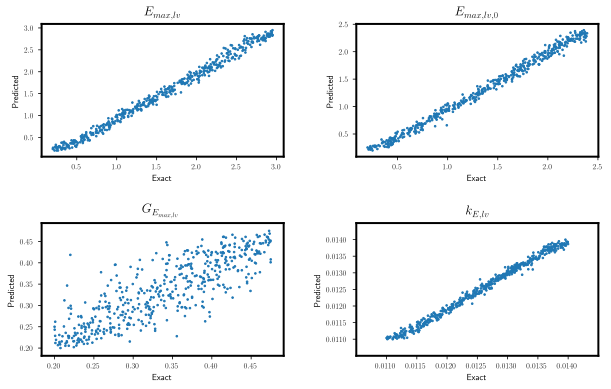

In [9]:
plot_dnn_performance(4000)

In [10]:
rpm4000 = get_results_table(4000)
rpm4000

HR   SAPM    SAPS   SAPD   PAPM   PAPS   PAPD   LVEF  \
Min exact             60.00  72.99   88.17  65.32  16.17  27.55  10.45  33.73   
Max exact             78.95  99.16  134.78  81.35  22.39  31.69  17.74  63.91   
Mean exact            66.69  89.76  119.94  74.67  18.42  29.18  13.04  53.40   
SD exact               3.87   5.53    9.69   3.54   1.19   0.78   1.40   6.57   
Min predicted         60.00  72.69   87.42  64.03  16.12  27.51  10.41  32.87   
Max predicted         83.33  99.34  135.00  81.52  22.75  31.95  18.14  64.48   
Mean predicted        66.69  89.79  119.85  74.75  18.39  29.16  13.01  53.50   
SD predicted           4.14   6.01   10.58   3.83   1.29   0.85   1.52   7.13   
Mean error matrix      0.64   0.56    1.00   0.40   0.13   0.11   0.15   0.71   
Mean rel error * 100   0.95   0.65    0.88   0.55   0.71   0.37   1.16   1.41   
SD error               1.24   0.51    1.01   0.33   0.12   0.09   0.14   0.61   
CI min                 0.53   0.52    0.91   0.38   0.12   0.10   0.14   0.66   
CI max                 0.75   0.61    1.09   0.43   0.14   0.12   0.17   0.76   

                       LVEDV   LVESV    CI   PCPW  
Min exact             134.31   48.47  0.83   5.98  
Max exact             200.82  132.10  2.37  14.04  
Mean exact            157.20   74.11 -1.90   9.00  
SD exact               14.55   17.29  0.32   1.61  
Min predicted         134.09   48.26  0.75   5.93  
Max predicted         208.90  139.54  2.39  14.63  
Mean predicted        157.72   74.35 -1.89   8.97  
SD predicted           16.00   19.03  0.35   1.75  
Mean error matrix       1.50    1.81  0.04   0.17  
Mean rel error * 100    0.91    2.30  2.44   1.85  
SD error                1.60    1.90  0.04   0.14  
CI min                  1.36    1.64  0.04   0.16  
CI max                  1.64    1.98  0.04   0.18

## RPM = 5000

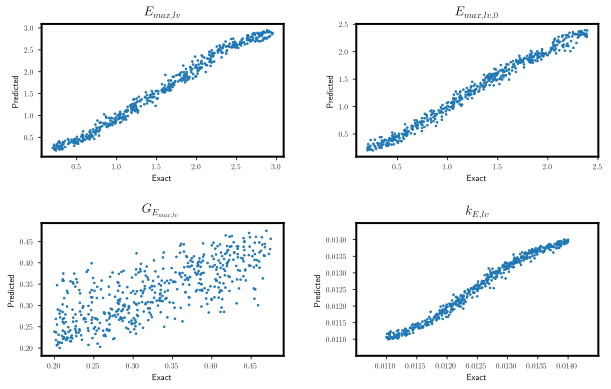

In [11]:
plot_dnn_performance(5000)

In [12]:
rpm5000 = get_results_table(5000)
rpm5000

HR   SAPM    SAPS   SAPD   PAPM   PAPS   PAPD   LVEF  \
Min exact             62.50  77.40   84.84  73.68  15.36  26.93   9.56  40.27   
Max exact             86.79  96.67  127.22  81.39  18.40  29.70  12.76  67.82   
Mean exact            70.92  89.18  111.35  78.09  16.66  27.94  11.03  55.14   
SD exact               6.10   4.67   10.06   2.09   0.68   0.58   0.74   6.95   
Min predicted         62.50  77.47   84.93  73.74  15.27  26.89   9.45  40.12   
Max predicted         85.08  97.06  128.54  81.60  18.41  29.76  12.73  68.13   
Mean predicted        70.82  89.11  111.15  78.09  16.67  27.96  11.02  55.34   
SD predicted           6.00   4.94   10.73   2.16   0.72   0.63   0.78   7.31   
Mean error matrix      0.93   0.40    0.96   0.15   0.06   0.07   0.06   0.65   
Mean rel error * 100   1.28   0.45    0.89   0.19   0.37   0.24   0.59   1.21   
SD error               1.80   0.33    0.83   0.13   0.04   0.06   0.05   0.59   
CI min                 0.77   0.37    0.89   0.14   0.06   0.06   0.06   0.60   
CI max                 1.09   0.43    1.03   0.16   0.06   0.07   0.07   0.70   

                       LVEDV   LVESV    CI  PCPW  
Min exact             120.10   38.95  0.00  5.05  
Max exact             180.88  105.52  1.63  9.64  
Mean exact            141.97   64.40 -0.91  6.86  
SD exact               12.41   15.12  0.41  1.03  
Min predicted         120.07   38.70  0.00  4.92  
Max predicted         183.70  107.11  1.69  9.66  
Mean predicted        141.66   64.07 -0.91  6.88  
SD predicted           13.45   16.04  0.44  1.09  
Mean error matrix       1.40    1.44  0.04  0.09  
Mean rel error * 100    0.97    2.26  7.44  1.29  
SD error                1.13    1.20  0.03  0.07  
CI min                  1.30    1.33  0.03  0.08  
CI max                  1.50    1.54  0.04  0.10

## RPM = 6000

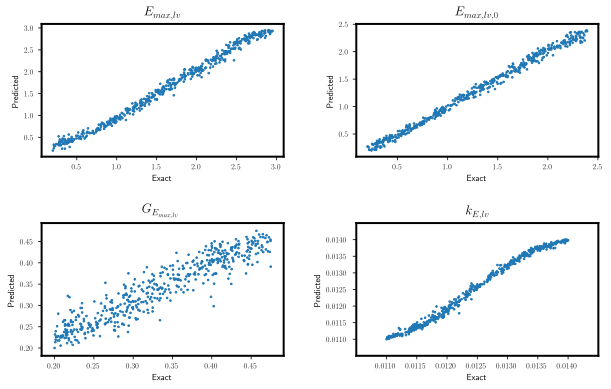

In [13]:
plot_dnn_performance(6000)

In [14]:
rpm6000 = get_results_table(6000)
rpm6000

HR   SAPM    SAPS   SAPD      PAPM   PAPS      PAPD  \
Min exact             57.69  90.38   94.93  88.03  1.37e+01  25.81  7.64e+00   
Max exact             68.18  95.70  107.85  89.71  1.40e+01  26.46  7.84e+00   
Mean exact            59.98  92.48   99.17  89.13  1.38e+01  26.08  7.68e+00   
SD exact               1.06   1.34    3.47   0.34  6.01e-02   0.12  3.47e-02   
Min predicted         57.69  90.21   94.69  87.97  1.37e+01  25.78  7.64e+00   
Max predicted         68.18  95.75  107.99  89.73  1.41e+01  26.52  7.87e+00   
Mean predicted        60.01  92.47   99.15  89.13  1.38e+01  26.09  7.68e+00   
SD predicted           1.18   1.37    3.53   0.35  6.59e-02   0.13  3.84e-02   
Mean error matrix      0.34   0.11    0.28   0.03  8.38e-03   0.02  4.33e-03   
Mean rel error * 100   0.57   0.12    0.28   0.03  6.06e-02   0.07  5.61e-02   
SD error               0.79   0.13    0.39   0.02  7.49e-03   0.02  5.02e-03   
CI min                 0.27   0.10    0.25   0.02  7.73e-03   0.02  3.89e-03   
CI max                 0.41   0.12    0.31   0.03  9.04e-03   0.02  4.77e-03   

                       LVEF   LVEDV  LVESV        CI  PCPW  
Min exact             60.72   83.69  25.34  0.00e+00  2.90  
Max exact             70.71  117.85  46.29  1.71e-01  3.90  
Mean exact            67.47   97.64  31.86 -2.06e-02  3.43  
SD exact               1.85    6.44   3.76  3.43e-02  0.17  
Min predicted         60.41   84.29  25.28  0.00e+00  2.85  
Max predicted         70.63  120.29  47.62  1.83e-01  3.94  
Mean predicted        67.54   97.39  31.72 -2.13e-02  3.43  
SD predicted           2.02    6.93   4.07  3.66e-02  0.18  
Mean error matrix      0.30    0.79   0.50  2.98e-03  0.02  
Mean rel error * 100   0.45    0.81   1.57  6.06e+00  0.63  
SD error               0.22    0.55   0.36  4.88e-03  0.01  
CI min                 0.28    0.74   0.47  2.56e-03  0.02  
CI max                 0.32    0.84   0.53  3.41e-03  0.02

## Comparison between RPM levels

We superpose the predicted vs exact hemodynamic quantities that were calculated from the simulation test data.

In [17]:
def load_X_data(RPM):
    Xhat = pd.read_csv(results_folders_LVAD[RPM]+filename_pred, header=None)
    X = pd.read_csv(results_folders_LVAD[RPM]+filename_exact, header=None)
    # Format columns
    cols = [
        'HR','SAPM','SAPS','SAPD',
        'PAPM','PAPS','PAPD','LVEF',
        'LVEDV', 'LVESV', 'CI', 'PCPW'
    ]
    Xhat.columns = cols
    X.columns = cols
    # Take abs (values of cardiac index are negative)
    X.CI = X.CI.apply(np.abs)
    Xhat.CI = Xhat.CI.apply(np.abs)
    # Join
    return X.join(Xhat, rsuffix='_hat')

In [18]:
X4000 = load_X_data(4000)
X5000 = load_X_data(5000)
X6000 = load_X_data(6000)

In [19]:
X4000['RPM'] = 4000
X5000['RPM'] = 5000
X6000['RPM'] = 6000

In [20]:
data = pd.concat([X4000, X5000, X6000])

In [21]:
def plt_compare(data, col, ax, legend=None):
    # Plot identity line
    coord1 = min(data[col].min(), data[col+'_hat'].min())
    coord2 = max(data[col].max(), data[col+'_hat'].max())
    ax.plot([coord1, coord2], [coord1, coord2], '--k')
    # Scatter plot predicted vs exact
    sns.scatterplot(x=col, y=col+'_hat', data=data, ax=ax, hue='RPM', legend=legend)
    ax.set_xlabel('$'+col+'$')
    ax.set_ylabel('$\widehat{' + col + '}$')

In [22]:
cols = [
    'HR','SAPM','SAPS','SAPD',
    'PAPM','PAPS','PAPD','LVEF',
    'LVEDV', 'LVESV', 'CI', 'PCPW'
]

### Relative error of hemodynamic quantities

Notes:

* For the Cardiac Index, many NaN values are ignored (division by zero). 5 values above 100% were set to NaN and thus ignored too.
* The relative error calculation in the plot is somewhat different from the mean relative error shown in summary tables:
    * In summary tables, division by zero are prevented by computing the relative error as follows: `mean(abs(Xexact-Xpredicted)./(abs(Xexact)+1e-2))`
    * In the plot above, division by zero is handled only for cardiac index, by ignoring the values

In [56]:
# Compute relative error for each sample
for col in cols:
    data[col+'_relerr'] = np.abs((data[col]-data[col+'_hat']) / data[col]) * 100
    print(data[col+'_relerr'].count())

1500
1500
1500
1500
1500
1500
1500
1500
1500
1500
1228
1500


In [57]:
data

HR   SAPM    SAPS   SAPD   PAPM   PAPS   PAPD   LVEF   LVEDV  LVESV  \
0    65.22  90.85  122.58  74.99  18.25  29.20  12.77  58.17  142.95  59.80   
1    62.50  94.70  126.60  78.76  16.72  28.00  11.08  57.53  158.08  67.13   
2    65.22  92.61  126.44  75.70  18.19  29.00  12.79  54.78  149.25  67.49   
3    62.50  93.79  126.44  77.46  17.36  28.54  11.77  58.57  148.72  61.61   
4    62.50  94.98  128.96  77.99  17.53  28.49  12.05  53.21  162.69  76.12   
..     ...    ...     ...    ...    ...    ...    ...    ...     ...    ...   
495  60.00  93.77  102.29  89.50  13.78  26.01   7.67  70.09   92.12  27.55   
496  60.00  91.81   96.98  89.22  13.84  26.15   7.69  70.16   90.47  27.00   
497  57.69  94.84  105.30  89.60  13.74  25.92   7.66  68.26   93.34  29.63   
498  60.00  93.16  100.80  89.35  13.82  26.12   7.68  69.79   89.80  27.13   
499  60.00  92.34   98.79  89.11  13.81  26.08   7.68  68.56   93.79  29.49   

     ...  SAPS_relerr  SAPD_relerr  PAPM_relerr  PAPS_relerr  PAPD_relerr  \
0    ...     2.56e-01         0.28     7.05e-01     7.07e-01         0.70   
1    ...     5.54e-01         0.36     3.46e-01     2.96e-02         0.82   
2    ...     1.03e-01         0.02     1.11e-01     1.39e-01         0.08   
3    ...     2.56e-02         0.24     9.67e-01     5.60e-01         1.46   
4    ...     1.10e+00         0.29     2.00e-01     3.33e-01         0.83   
..   ...          ...          ...          ...          ...          ...   
495  ...     6.71e-03         0.01     3.55e-03     7.76e-03         0.02   
496  ...     5.81e-03         0.01     5.60e-02     5.54e-02         0.06   
497  ...     3.38e-02         0.03     6.24e-04     1.01e-02         0.02   
498  ...     4.91e-01         0.02     2.30e-03     2.61e-02         0.05   
499  ...     5.20e-01         0.03     1.73e-01     2.08e-01         0.11   

     LVEF_relerr  LVEDV_relerr  LVESV_relerr  CI_relerr  PCPW_relerr  
0           1.15          0.68          2.27       1.14         1.05  
1           1.64          1.19          3.38       0.84         1.33  
2           0.62          0.68          1.45       0.18         0.08  
3           0.68          0.56          0.40       0.04         2.15  
4           2.00          0.52          2.78       1.43         1.58  
..           ...           ...           ...        ...          ...  
495         0.22          1.42          1.93      19.38         0.16  
496         0.36          0.71          1.54        NaN         0.35  
497         0.25          1.91          1.38      25.25         0.95  
498         0.62          0.91          2.33      11.68         0.51  
499         0.72          1.29          2.83      44.38         0.89  

[1500 rows x 37 columns]

In [64]:
# We have two extreme outliers for CI (> 10^11)
# We set those values as NaN
data.loc[data.CI_relerr > 1e11, 'CI_relerr'] = [np.nan, np.nan]

In [77]:
data.loc[data.CI_relerr > 100, 'CI_relerr'] = [np.nan, np.nan, np.nan]

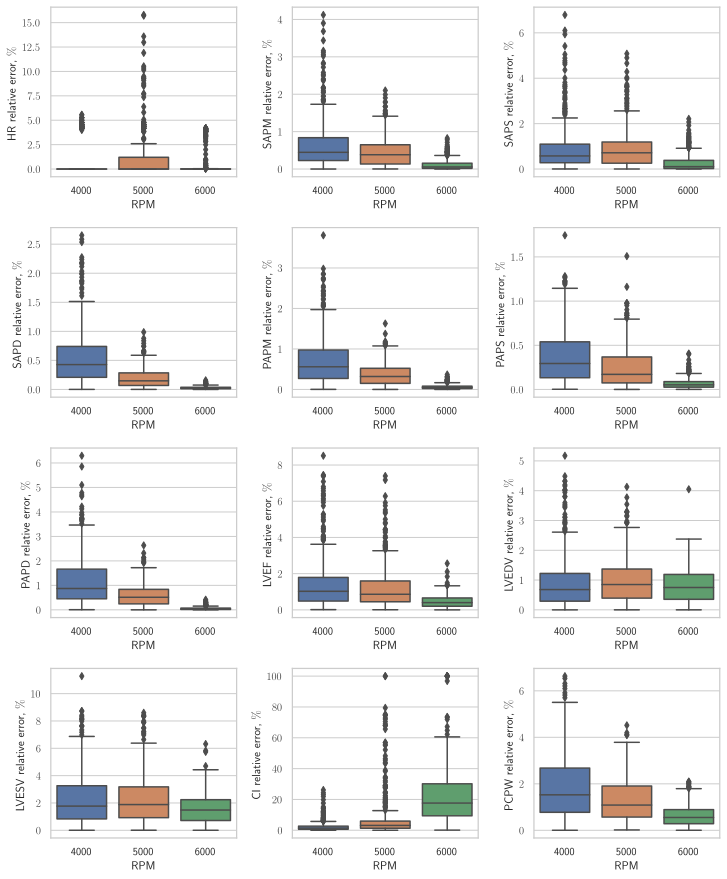

In [78]:
fig, ax = plt.subplots(4, 3, figsize=(12, 15))
axlst = ax.ravel()
sns.set(style="whitegrid")

for i, col in enumerate(cols):
    sns.boxplot(x='RPM', y=col+'_relerr', data=data, ax=axlst[i])
    axlst[i].set_ylabel(col + ' relative error, $\%$')

plt.subplots_adjust(wspace=.3, hspace=.3)

### Predicted vs exact hemodynamic quantities

In [23]:
fig, ax = plt.subplots(4, 3, figsize=(12, 15))
axlst = ax.ravel()

for i, col in enumerate(cols):
    plt_compare(data, col, axlst[i], 'full' if i == 1 else None)
plt.subplots_adjust(wspace=.3, hspace=.3)
sns.despine()
plt.savefig("rpm-comparison.svg")

Predicted vs exact hemodynamic quantities for different RPM levels. Heart rate (HR), mean systemic arterial pressure (SAPM), systolic systemic arterial pressure (SAPS), diastolic systemic arterial pressure (SAPD), mean pulmonary arterial pressure (PAPM), systolic pulmonary arterial pressure (PAPS), diastolic pulmonary arterial pressure (PAPD), left ventricular ejection fraction (LVEF), left ventricular end diastolic volume (LVEDV), left ventricular end systolic volume (LVESV), cardiac index (CI), pulmonary capillary wedge pressure (PCWP).

# Appendix

*Note: this cell is ignored in the PDF.*

## Parameters of the model

The two models used, `Ursino1998Model_VAD2` and `Ursino1998Model`, extend the model `ModelParametersNH` that defines all the parameters.

In [24]:
filepath = '../modelica/original/Mathcard.mo'

In [25]:
with open(filepath, 'r') as f:
    filecontent = f.read()

In [26]:
model_start = "model ModelParametersNH"
model_end = "end ModelParametersNH;"

In [27]:
# All parameters have the same name format: Param_XXX
params = []
reading_model = False
for line in filecontent.split('\n'):
    # Remove any indentation
    line = line.strip()
    if line == model_start:
        reading_model = True
    elif line == model_end:
        reading_model = False
    elif reading_model:
        params.append(line)
    # else: outside the model...
print(len(params))
print('\n'.join(params))

117
parameter Real Param_LeftAtrium_C = 19.23;
parameter Real Param_LeftAtrium_V0(unit = "ml") = 25;
parameter Real Param_LeftAtrium_Vu0(unit = "ml") = 25;
parameter Real Param_MitralicValve_R(unit = "mmHg.s2/ml") = 2.5 * 0.001;
parameter Real Param_LeftVentricle_V0(unit = "ml") = 16.77;
parameter Real Param_LeftVentricle_kR(unit = "s/ml") = 3.75 * 0.0001;
parameter Real Param_LeftVentricle_Emax0 = 2.95;
parameter Real Param_LeftVentricle_EmaxRef0 = 2.392;
parameter Real Param_LeftVentricle_AGain_Emax = 0.475;
parameter Real Param_LeftVentricle_ADelay_Emax = 2;
parameter Real Param_LeftVentricle_ATau_Emax = 8;
parameter Real Param_LeftVentricle_P0(unit = "mmHg") = 1.5;
parameter Real Param_LeftVentricle_kE(unit = "1/ml") = 0.014;
parameter Real Param_LeftVentricle_TSys0(unit = "s") = 0.5;
parameter Real Param_LeftVentricle_kSys(unit = "s2") = 0.075;
parameter Real Param_LeftVentricle_TRef0 = 0.58;
parameter Real Param_LeftVentricle_AGain_Ts = -0.13;
parameter Real Param_LeftVentricle_A